# Vertical multi-omics integration - analysis of matched datasets 

<!-- In this notebook we will perform exploratory analysis and joint dimensionality reduction on matched scRNA-seq and scATAC-seq data of developing brain cortex from [Trevino et al.2021](https://www.cell.com/cell/fulltext/S0092-8674(21)00942-9?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867421009429%3Fshowall%3Dtrue), focusing on differentiation of excitatory glutamatergic neurons.

What we will cover:

1. Construction of objects for multi-modal data handling using [muon]()
2. Joint exploratory data analysis
3. Dimensionality reduction with multi-view models ("vertical" integration) using [Multi-Omics Factor Analysis]() and [Weighted Nearest-Neighbor graphs]()
4. Basics of feature-wise analysis

What we _won't_ cover:

1. Methods for aggregation of expression and accessibility profiles from single-cells for inference of regulatory links (see [SEAcells]()) -->


In [7]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import scipy

import muon as mu
import anndata

import pyranges

## Plotting utils
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [8]:
## Set plotting parameters for scanpy
sc.set_figure_params(figsize=[9,9], color_map = 'viridis_r')

<!-- <div class="alert alert-block alert-info"> 
    
    <b>New to python?</b> Don't panic! Use [help] to 
    
</div>
 -->

## Load single-omic data

The data for each omic view is stored in [`AnnData`](https://anndata.readthedocs.io/en/latest/index.html) format. An `AnnData` object allows us to store a matrix and add annotations to its different dimensions, defined as “observations” (i.e. cells), and measured “variables” (i.e. genes for the RNA view and peaks for the ATAC view). See [this tutorial](https://anndata-tutorials.readthedocs.io/en/latest/getting-started.html) for a quick-start on the structure of AnnData objects.

We downloaded the original datasets following the instructions in https://github.com/GreenleafLab/brainchromatin, which we further cleaned, filtered and  converted to `AnnData` objects saved in `.h5ad` files. Pre-processing and dimensionality reduction for the individual modalities is shown in [this notebook]().

In [9]:
## Put the path to the data here
# # from AWS instance
# data_dir = "/data/multiomics/gr2_matched_vertical"
## or
# data_dir = "/path/to/data/gr2_matched_vertical"
data_dir = "/home/jovyan/mount/gdrive/sc-multiomics-course-2022/gr2_matched_vertical/"

In [68]:
rna_adata = sc.read_h5ad('{d}/Trevino_multiome_RNA_clean.preprocessed.h5ad'.format(d=data_dir))
atac_adata = sc.read_h5ad('{d}/Trevino_multiome_ATAC_clean.preprocessed.h5ad'.format(d=data_dir))

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


We can access the annotations on cells using `adata.obs` (cell type annotations are stored in `adata.obs["cluster_name"]`, while cells that belong to the glutamatergic neuron differentiation trajectory are marked in `adata.obs['in_GluN_trajectory']`)

In [14]:
rna_adata.obs

Sample_ID Sample_Age  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA  hft_ctx_w21_dc1r3_r1      pcw21   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA  hft_ctx_w21_dc1r3_r1      pcw21   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA  hft_ctx_w21_dc1r3_r1      pcw21   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT  hft_ctx_w21_dc1r3_r1      pcw21   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC  hft_ctx_w21_dc1r3_r1      pcw21   
...                                                     ...        ...   
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG  hft_ctx_w21_dc2r2_r2      pcw21   
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG  hft_ctx_w21_dc2r2_r2      pcw21   
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA  hft_ctx_w21_dc2r2_r2      pcw21   
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG  hft_ctx_w21_dc2r2_r2      pcw21   
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA  hft_ctx_w21_dc2r2_r2      pcw21   

                                      Sample_Batch      Cell_Barcode  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA     b2020_11  AAACAGCCAGCAATAA   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA     b2020_11  AAACAGCCAGCTCATA   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA     b2020_11  AAACATGCACGTTACA   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT     b2020_11  AAACATGCATAAACCT   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC     b2020_11  AAACATGCATTTAAGC   
...                                            ...               ...   
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG     b2020_11  TTTGGTGCATGAATAG   
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG     b2020_11  TTTGTCCCAGTTTACG   
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA     b2020_11  TTTGTCTAGTGAGCAA   
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG     b2020_11  TTTGTGAAGACAGGCG   
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA     b2020_11  TTTGTGTTCGTCCTTA   

                                       RNA_Counts  RNA_Features  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA        2494          1435   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA        2257          1288   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA        3485          1632   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT        2266          1247   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC        2741          1495   
...                                           ...           ...   
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG        4538          1910   
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG        5925          2155   
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA        3496          1631   
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG        4099          1935   
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA        6520          2514   

                                      Dissociation_ID  percentMT  percentRibo  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA               A   0.000796     0.017516   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA               A   0.012798     0.033098   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA               A   0.031098     0.039372   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT               A   0.012319     0.021557   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC               A   0.012341     0.020690   
...                                               ...        ...          ...   
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG               B   0.006583     0.010753   
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG               B   0.012747     0.012244   
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA               B   0.003410     0.025291   
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG               B   0.061999     0.044979   
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA               B   0.001069     0.014207   

                                       CR_Estimated_number_of_cells clusterID  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA                          3534       c10   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA                          3534        c2   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA                          3534        c0   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT                          3534        c4   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC                          3534        c4   
...                             

In [11]:
atac_adata.obs

Sample_ID Sample_Age  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA  hft_ctx_w21_dc1r3_r1      pcw21   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA  hft_ctx_w21_dc1r3_r1      pcw21   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA  hft_ctx_w21_dc1r3_r1      pcw21   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT  hft_ctx_w21_dc1r3_r1      pcw21   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC  hft_ctx_w21_dc1r3_r1      pcw21   
...                                                     ...        ...   
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG  hft_ctx_w21_dc2r2_r2      pcw21   
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG  hft_ctx_w21_dc2r2_r2      pcw21   
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA  hft_ctx_w21_dc2r2_r2      pcw21   
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG  hft_ctx_w21_dc2r2_r2      pcw21   
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA  hft_ctx_w21_dc2r2_r2      pcw21   

                                      Sample_Batch      Cell_Barcode  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA     b2020_11  AAACAGCCAGCAATAA   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA     b2020_11  AAACAGCCAGCTCATA   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA     b2020_11  AAACATGCACGTTACA   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT     b2020_11  AAACATGCATAAACCT   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC     b2020_11  AAACATGCATTTAAGC   
...                                            ...               ...   
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG     b2020_11  TTTGGTGCATGAATAG   
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG     b2020_11  TTTGTCCCAGTTTACG   
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA     b2020_11  TTTGTCTAGTGAGCAA   
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG     b2020_11  TTTGTGAAGACAGGCG   
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA     b2020_11  TTTGTGTTCGTCCTTA   

                                      Dissociation_ID          Assay  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA               A  Multiome_ATAC   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA               A  Multiome_ATAC   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA               A  Multiome_ATAC   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT               A  Multiome_ATAC   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC               A  Multiome_ATAC   
...                                               ...            ...   
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG               B  Multiome_ATAC   
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG               B  Multiome_ATAC   
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA               B  Multiome_ATAC   
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG               B  Multiome_ATAC   
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA               B  Multiome_ATAC   

                                       n_genes_by_counts  total_counts  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA               4528  15330.038086   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA               7016  17174.105469   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA               8604  18767.230469   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT              10956  20091.273438   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC              10255  19432.011719   
...                                                  ...           ...   
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG               3072  10682.956055   
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG              13272  21146.341797   
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA               9286  18510.812500   
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG               2877  11088.833008   
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA               1167   6971.208008   

                                          LSI_f1     LSI_f2 leiden  
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA -10.047495  20.719328     10  
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA  17.179033   7.145973      5  
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA  -5.839355 -13.834993      0  
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT  29.500624  18.387838      4  
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC  24.970009  17.258392      4  
...                                          ...        ...    ...  
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG  17.454895  13.873288

We can access the annotation on features (genes for RNA modality, peaks for ATAC modality) with `adata.var`. Here we also store the genomic coordinates of the peaks, which we will use later.

In [12]:
rna_adata.var

gene_id             gene_type   gene_name  n_cells  \
AL627309.1  ENSG00000238009.6               lincRNA  AL627309.1       41   
AL627309.5  ENSG00000241860.6  processed_transcript  AL627309.5       77   
AL669831.2  ENSG00000229905.1         antisense_RNA  AL669831.2        4   
AL669831.5  ENSG00000237491.8               lincRNA  AL669831.5      593   
FAM87B      ENSG00000177757.2               lincRNA      FAM87B        6   
...                       ...                   ...         ...      ...   
MT-ND4L     ENSG00000212907.2        protein_coding     MT-ND4L     4748   
MT-ND4      ENSG00000198886.2        protein_coding      MT-ND4     8286   
MT-ND5      ENSG00000198786.2        protein_coding      MT-ND5     6744   
MT-ND6      ENSG00000198695.2        protein_coding      MT-ND6     1939   
MT-CYB      ENSG00000198727.2        protein_coding      MT-CYB     8282   

            highly_variable     means  dispersions  dispersions_norm  \
AL627309.1            False  0.082113     3.224278         -0.358397   
AL627309.5            False  0.137769     3.185355         -0.458135   
AL669831.2            False  0.008042     3.265629         -0.252438   
AL669831.5            False  0.912602     3.528598         -0.295463   
FAM87B                 True  0.016905     3.909067          1.396342   
...                     ...       ...          ...               ...   
MT-ND4L               False  3.022517     3.464332         -1.226362   
MT-ND4                False  5.501800     4.778122         -0.744001   
MT-ND5                False  4.066192     3.993302         -0.297075   
MT-ND6                False  1.737467     3.249987         -1.541235   
MT-CYB                False  5.516113     4.911272         -0.508697   

                     GeneID Chromosome     Start       End       GeneName  
AL627309.1  ENSG00000238009       chr1   89295.0  133723.0   RP11-34P13.7  
AL627309.5  ENSG00000241860       chr1  141474.0  173862.0  RP11-34P13.13  
AL669831.2  ENSG00000229905       chr1  760911.0  761989.0  RP11-206L10.4  
AL669831.5  ENSG00000237491       chr1  778770.0  810060.0  RP11-206L10.9  
FAM87B      ENSG00000177757       chr1  817371.0  819837.0         FAM87B  
...                     ...        ...       ...       ...            ...  
MT-ND4L     ENSG00000212907      chrMT   10470.0   10766.0        MT-ND4L  
MT-ND4      ENSG00000198886      chrMT   10760.0   12137.0         MT-ND4  
MT-ND5      ENSG00000198786      chrMT   12337.0   14148.0         MT-ND5  
MT-ND6      ENSG00000198695      chrMT   14149.0   14673.0         MT-ND6  
MT-CYB      ENSG00000198727      chrMT   14747.0   15887.0         MT-CYB  

[26572 rows x 13 columns]

In [13]:
atac_adata.var

seqnames     start       end  width strand             name  \
0          chr1    180451    180951    501      *        c7_peak_1   
1          chr1    181254    181754    501      *        c2_peak_1   
2          chr1    191223    191723    501      *        c9_peak_1   
3          chr1    630059    630559    501      *        c6_peak_5   
4          chr1    633776    634276    501      *        c8_peak_4   
...         ...       ...       ...    ...    ...              ...   
467308    chr22  50733529  50734029    501      *   c9_peak_116149   
467309    chr22  50739954  50740454    501      *   c2_peak_113394   
467310    chr22  50756935  50757435    501      *    c5_peak_81501   
467312    chr22  50775143  50775643    501      *   c8_peak_104552   
467313    chr22  50783378  50783878    501      *  c6_peak_126089b   

        n_cells_by_counts  mean_counts  pct_dropout_by_counts  total_counts  \
0                      34     0.016861              99.621423    151.430237   
1                      77     0.030596              99.142634    274.779602   
2                      84     0.037461              99.064692    336.439209   
3                      61     0.025755              99.320788    231.303757   
4                      58     0.029463              99.354192    264.608612   
...                   ...          ...                    ...           ...   
467308                122     0.041067              98.641577    368.819977   
467309                 36     0.014530              99.599154    130.492874   
467310                 58     0.024575              99.354192    220.706482   
467312                 40     0.015740              99.554615    141.359543   
467313                670     0.140062              92.539806   1257.894775   

          GCbias  
0       0.506986  
1       0.748503  
2       0.582834  
3       0.429142  
4       0.443114  
...          ...  
467308  0.576846  
467309  0.568862  
467310  0.528942  
467312  0.582834  
467313  0.740519  

[308071 rows x 11 columns]

## Build multi-modal `MuData` object

We now want to store both data objects for both modalities in a single object, to facilitate multi-modal analysis. Here we will use [`muon`](https://muon.readthedocs.io/en/latest/index.html), a python framework for multi-omics data analysis.

`muon.MuData` is a multi-modal data container, that comprises a dictionary with `AnnData` objects, one per modality, in its `.mod` attribute. Just as `AnnData` objects themselves, they also contain attributes like `.obs` with annotation of observations (samples or cells), `.obsm` with their multidimensional annotations such as embeddings, etc. See [this tutorial](https://muon.readthedocs.io/en/latest/notebooks/quickstart_mudata.html) for a more detailed introduction to the `MuData` object structure.


In [15]:
mdata = mu.MuData({'rna': rna_adata, 'atac': atac_adata})
mdata.var_names_make_unique()

In [16]:
mdata

MuData object with n_obs × n_vars = 8981 × 334643
  2 modalities
    rna:	8981 x 26572
      obs:	'Sample_ID', 'Sample_Age', 'Sample_Batch', 'Cell_Barcode', 'RNA_Counts', 'RNA_Features', 'Dissociation_ID', 'percentMT', 'percentRibo', 'CR_Estimated_number_of_cells', 'clusterID', 'cluster_name', 'cluster_name_long', 'Assay', 'in_GluN_trajectory'
      var:	'gene_id', 'gene_type', 'gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'GeneID', 'Chromosome', 'Start', 'End', 'GeneName'
      uns:	'cluster_name_colors', 'hvg', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'
    atac:	8981 x 308071
      obs:	'Sample_ID', 'Sample_Age', 'Sample_Batch', 'Cell_Barcode', 'Dissociation_ID', 'Assay', 'n_genes_by_counts', 'total_counts', 'LSI_f1', 'LSI_f2', 'leiden'
      var:	'seqnames', 'start', 'end', 'width', 'strand', 'name', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'GCbias'
      uns:	'gene_activity_var', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
      obsm:	'X_lsi', 'X_pca', 'X_umap', 'gene_activity'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'

In [17]:
mdata.mod

{'rna': AnnData object with n_obs × n_vars = 8981 × 26572
     obs: 'Sample_ID', 'Sample_Age', 'Sample_Batch', 'Cell_Barcode', 'RNA_Counts', 'RNA_Features', 'Dissociation_ID', 'percentMT', 'percentRibo', 'CR_Estimated_number_of_cells', 'clusterID', 'cluster_name', 'cluster_name_long', 'Assay', 'in_GluN_trajectory'
     var: 'gene_id', 'gene_type', 'gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'GeneID', 'Chromosome', 'Start', 'End', 'GeneName'
     uns: 'cluster_name_colors', 'hvg', 'neighbors', 'pca', 'umap'
     obsm: 'X_pca', 'X_umap'
     varm: 'PCs'
     obsp: 'connectivities', 'distances',
 'atac': AnnData object with n_obs × n_vars = 8981 × 308071
     obs: 'Sample_ID', 'Sample_Age', 'Sample_Batch', 'Cell_Barcode', 'Dissociation_ID', 'Assay', 'n_genes_by_counts', 'total_counts', 'LSI_f1', 'LSI_f2', 'leiden'
     var: 'seqnames', 'start', 'end', 'width', 'strand', 'name', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_c

You can see the object now concatenates `.obs` from both assays in a single object, and the info about the original assay for each column is saved

In [18]:
mdata.obs

rna:Sample_ID rna:Sample_Age  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA  hft_ctx_w21_dc1r3_r1          pcw21   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA  hft_ctx_w21_dc1r3_r1          pcw21   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA  hft_ctx_w21_dc1r3_r1          pcw21   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT  hft_ctx_w21_dc1r3_r1          pcw21   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC  hft_ctx_w21_dc1r3_r1          pcw21   
...                                                     ...            ...   
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG  hft_ctx_w21_dc2r2_r2          pcw21   
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG  hft_ctx_w21_dc2r2_r2          pcw21   
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA  hft_ctx_w21_dc2r2_r2          pcw21   
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG  hft_ctx_w21_dc2r2_r2          pcw21   
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA  hft_ctx_w21_dc2r2_r2          pcw21   

                                      rna:Sample_Batch  rna:Cell_Barcode  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA         b2020_11  AAACAGCCAGCAATAA   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA         b2020_11  AAACAGCCAGCTCATA   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA         b2020_11  AAACATGCACGTTACA   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT         b2020_11  AAACATGCATAAACCT   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC         b2020_11  AAACATGCATTTAAGC   
...                                                ...               ...   
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG         b2020_11  TTTGGTGCATGAATAG   
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG         b2020_11  TTTGTCCCAGTTTACG   
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA         b2020_11  TTTGTCTAGTGAGCAA   
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG         b2020_11  TTTGTGAAGACAGGCG   
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA         b2020_11  TTTGTGTTCGTCCTTA   

                                       rna:RNA_Counts  rna:RNA_Features  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA            2494              1435   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA            2257              1288   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA            3485              1632   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT            2266              1247   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC            2741              1495   
...                                               ...               ...   
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG            4538              1910   
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG            5925              2155   
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA            3496              1631   
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG            4099              1935   
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA            6520              2514   

                                      rna:Dissociation_ID  rna:percentMT  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA                   A       0.000796   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA                   A       0.012798   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA                   A       0.031098   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT                   A       0.012319   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC                   A       0.012341   
...                                                   ...            ...   
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG                   B       0.006583   
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG                   B       0.012747   
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA                   B       0.003410   
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG                   B       0.061999   
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA                   B       0.001069   

                                       rna:percentRibo  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA         0.017516   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA         0.033098   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA         0.039372   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT         0.021557   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC         0.020690   
...                               

Observations and variables of the `MuData` object are global, which means that observations with the identical name (`.obs_names`) in different modalities are considered to be the same observation. This also means variable names (`.var_names`) should be unique.

**Note:** individual modalities inside the MuData container are stored as references to the original objects and are full-fledged AnnData objects, which can be operated independently with any tool that works on AnnData objects (such as the [`scanpy`](https://scanpy.readthedocs.io/en/stable/index.html) tools). So if we change the single-omic `AnnData` objects, the changes will be reflected in the container.

For example, if we add a column to the `.obs` of the RNA modality object, we can see the new column is also accessible from the container.


In [19]:
rna_adata.obs["new_col"] = 0
mdata["rna"]

AnnData object with n_obs × n_vars = 8981 × 26572
    obs: 'Sample_ID', 'Sample_Age', 'Sample_Batch', 'Cell_Barcode', 'RNA_Counts', 'RNA_Features', 'Dissociation_ID', 'percentMT', 'percentRibo', 'CR_Estimated_number_of_cells', 'clusterID', 'cluster_name', 'cluster_name_long', 'Assay', 'in_GluN_trajectory', 'new_col'
    var: 'gene_id', 'gene_type', 'gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'GeneID', 'Chromosome', 'Start', 'End', 'GeneName'
    uns: 'cluster_name_colors', 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

However, the column is not found in the common `.obs`

In [20]:
"rna:new_col" in mdata.obs.columns

False

To update the common obs, we can use the `.update_obs()` method, that syncs up the data.

In [21]:
mdata.update_obs()
mdata.obs["rna:new_col"]

hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA    0
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA    0
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA    0
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT    0
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC    0
                                        ..
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG    0
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG    0
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA    0
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG    0
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA    0
Name: rna:new_col, Length: 8981, dtype: int64

To update everything, not just the `obs`, we can use `mdata.update()`

In [22]:
rna_adata.obs.drop("new_col", axis=1, inplace=True)
mdata.obs.drop("rna:new_col", axis=1, inplace=True)
mdata.update()

Cleaning up

In [23]:
## Find and rename .obs columns that are common between modalities
common_obs = []
for c in rna_adata.obs.columns:
    try:
        common = all(rna_adata.obs[c] == atac_adata.obs[c])
    except:
        common = False
    if common:
        common_obs.append(c)

common_obs

['Sample_ID', 'Sample_Age', 'Sample_Batch', 'Cell_Barcode', 'Dissociation_ID']

In [24]:
mdata.obs.drop(['atac:' + x for x in common_obs], 1, inplace=True)
mdata.obs.columns = [x.strip("rna:") if x in ['rna:' + x for x in common_obs] else x for x in mdata.obs.columns]

/tmp/ipykernel_8646/896682402.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  mdata.obs.drop(['atac:' + x for x in common_obs], 1, inplace=True)


In [25]:
mdata.obs.columns

Index(['Sample_ID', 'Sample_Age', 'Sample_Batch', 'Cell_Barcode',
       'rna:RNA_Counts', 'rna:RNA_Features', 'Dissociation_ID',
       'rna:percentMT', 'rna:percentRibo', 'rna:CR_Estimated_number_of_cells',
       'rna:clusterID', 'rna:cluster_name', 'rna:cluster_name_long',
       'rna:Assay', 'rna:in_GluN_trajectory', 'atac:Assay',
       'atac:n_genes_by_counts', 'atac:total_counts', 'atac:LSI_f1',
       'atac:LSI_f2', 'atac:leiden'],
      dtype='object')

We can save the joint data object in `.h5mu` format

In [26]:
# output_dir = /path/to/outdir/
mdata.write("{d}/vertical_clean.h5mu".format(d=output_dir))

In [129]:
# mdata = mu.read("{d}/vertical_clean.h5mu".format(d=output_dir))

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Exercise 1

(warm-up question) How many cells are annotated as glutamatergic neurons? 

In [27]:
gluN_cluster_names_rna = [x for x in mdata.obs['rna:cluster_name'].unique() if 'GluN' in x]

# ...
# ...
# ...

## Exploratory data analysis

In the MuData object, we can now start comparing independent clustering of the two modalities

In [28]:
mdata.update_obs()

## Save embeddings from individual modalities in mdata.obsm
mdata.obsm['X_umap_rna'] = mdata['rna'].obsm['X_umap'].copy()
mdata.obsm['X_umap_atac'] = mdata['atac'].obsm['X_umap'].copy()

/home/jovyan/my-conda-envs/sc2022-multiomics/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'rna:gene_id' as categorical
/home/jovyan/my-conda-envs/sc2022-multiomics/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'rna:GeneID' as categorical
/home/jovyan/my-conda-envs/sc2022-multiomics/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categor

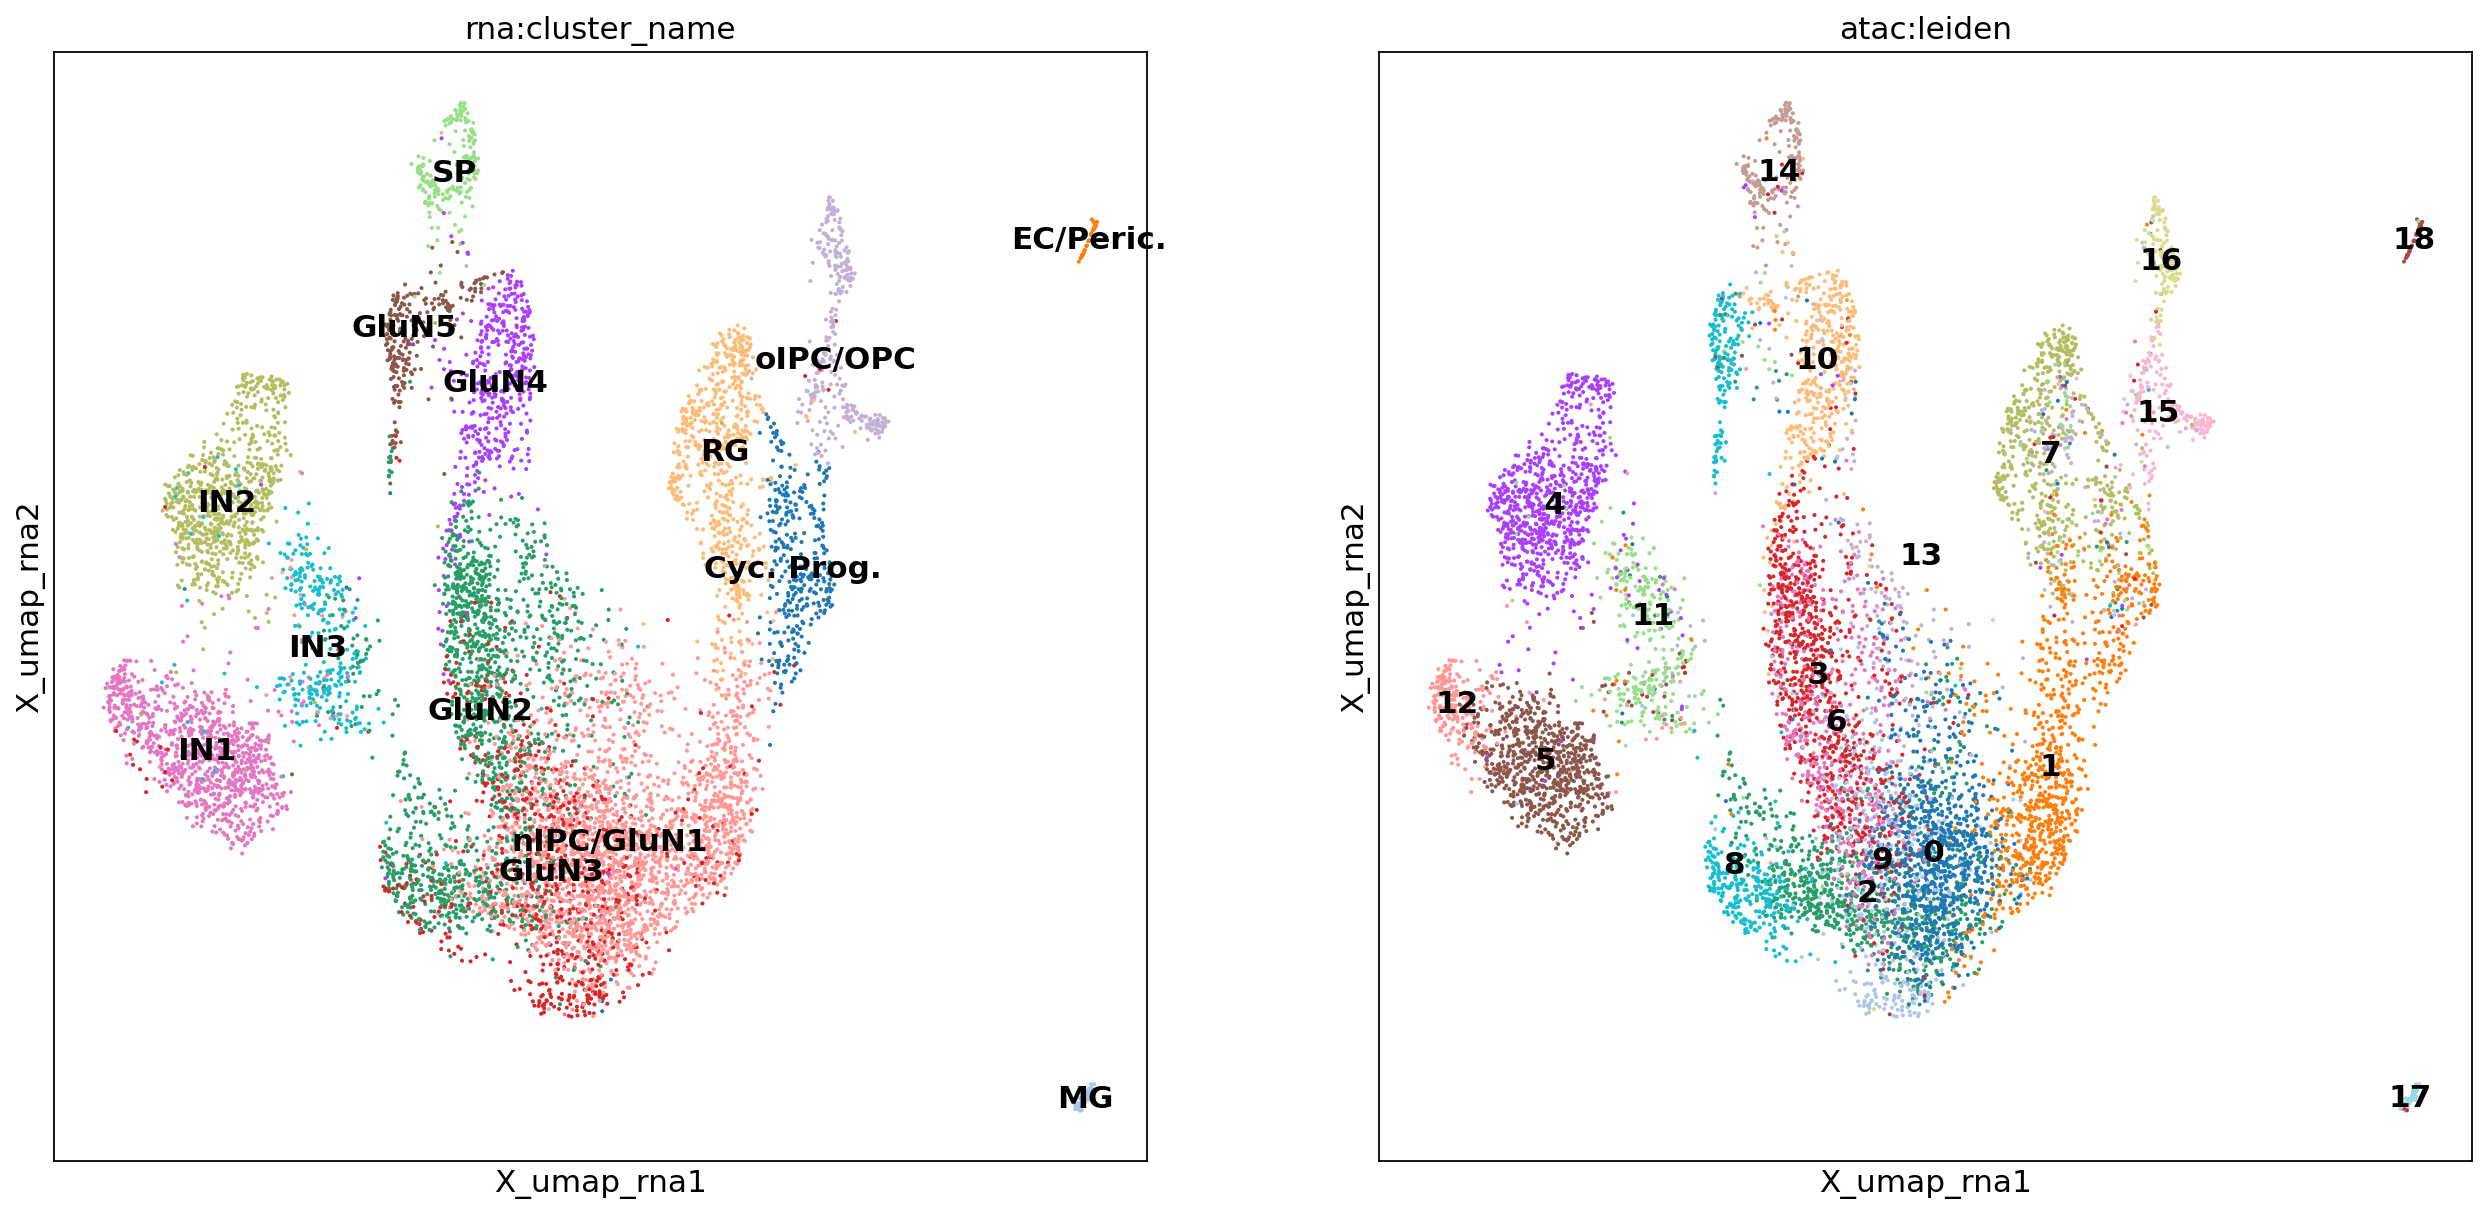

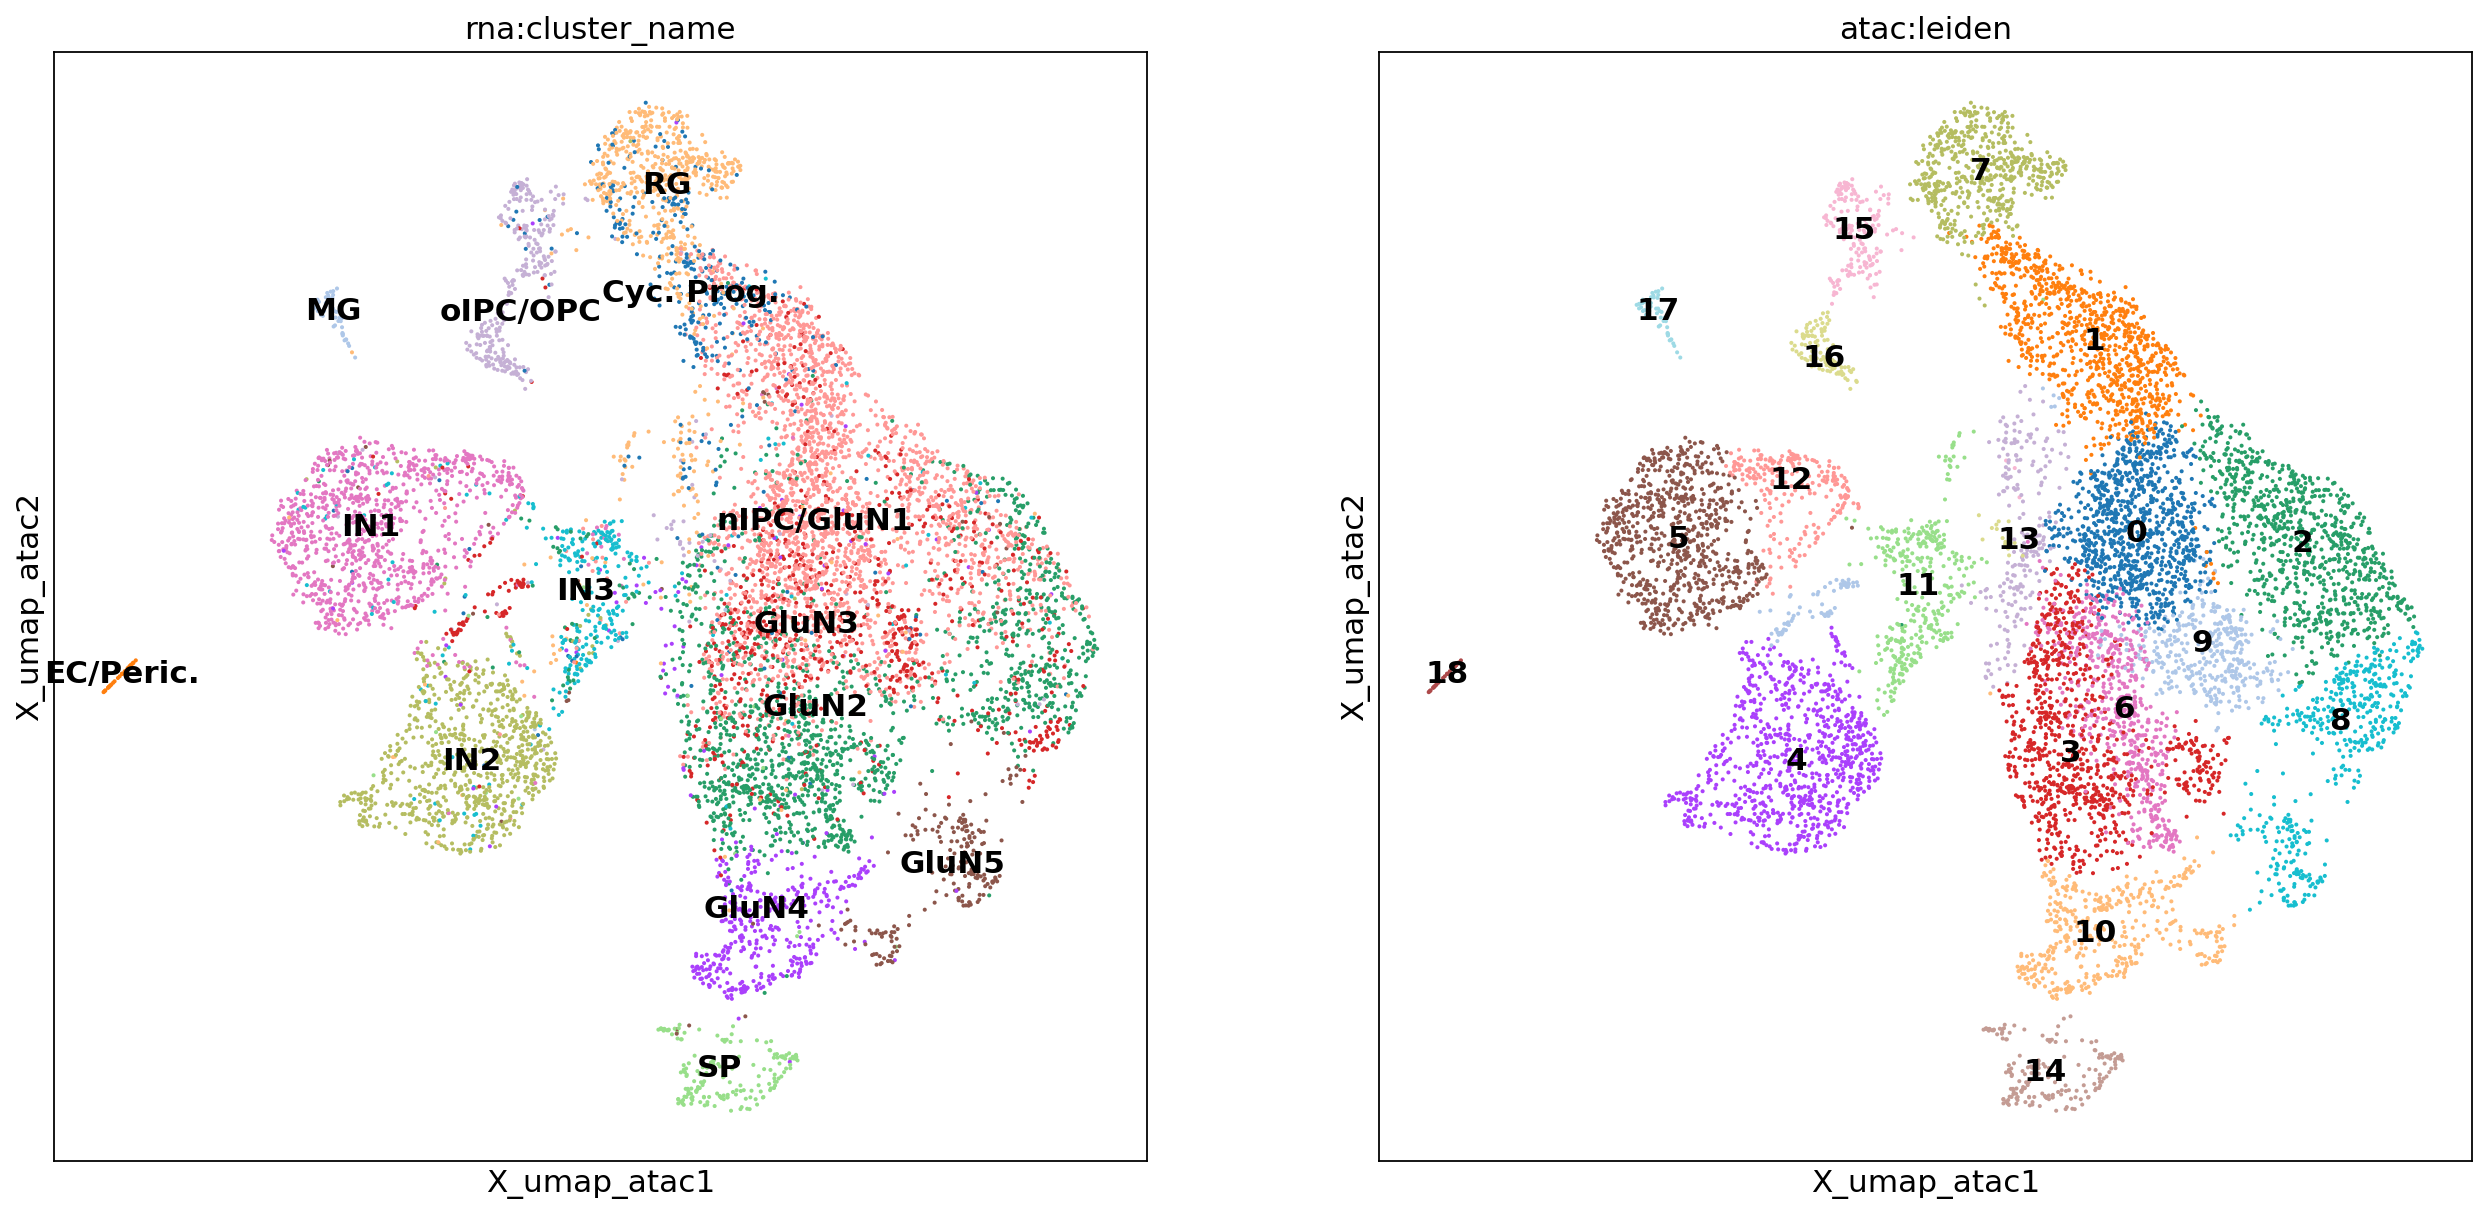

In [29]:
sc.pl.embedding(mdata, basis="X_umap_rna", color=['rna:cluster_name','atac:leiden'] , legend_loc='on data')
sc.pl.embedding(mdata, basis="X_umap_atac", color=['rna:cluster_name','atac:leiden'], legend_loc='on data')

### Exercise 2

Use the labels on the gene expression clusters to annotate the clusters in chromatin accessibility. Which RNA clusters are mixed in chromatin accessibility? The utility function `sc.metrics.confusion_matrix` might be useful here.

<AxesSubplot:xlabel='atac:leiden', ylabel='rna:cluster_name'>

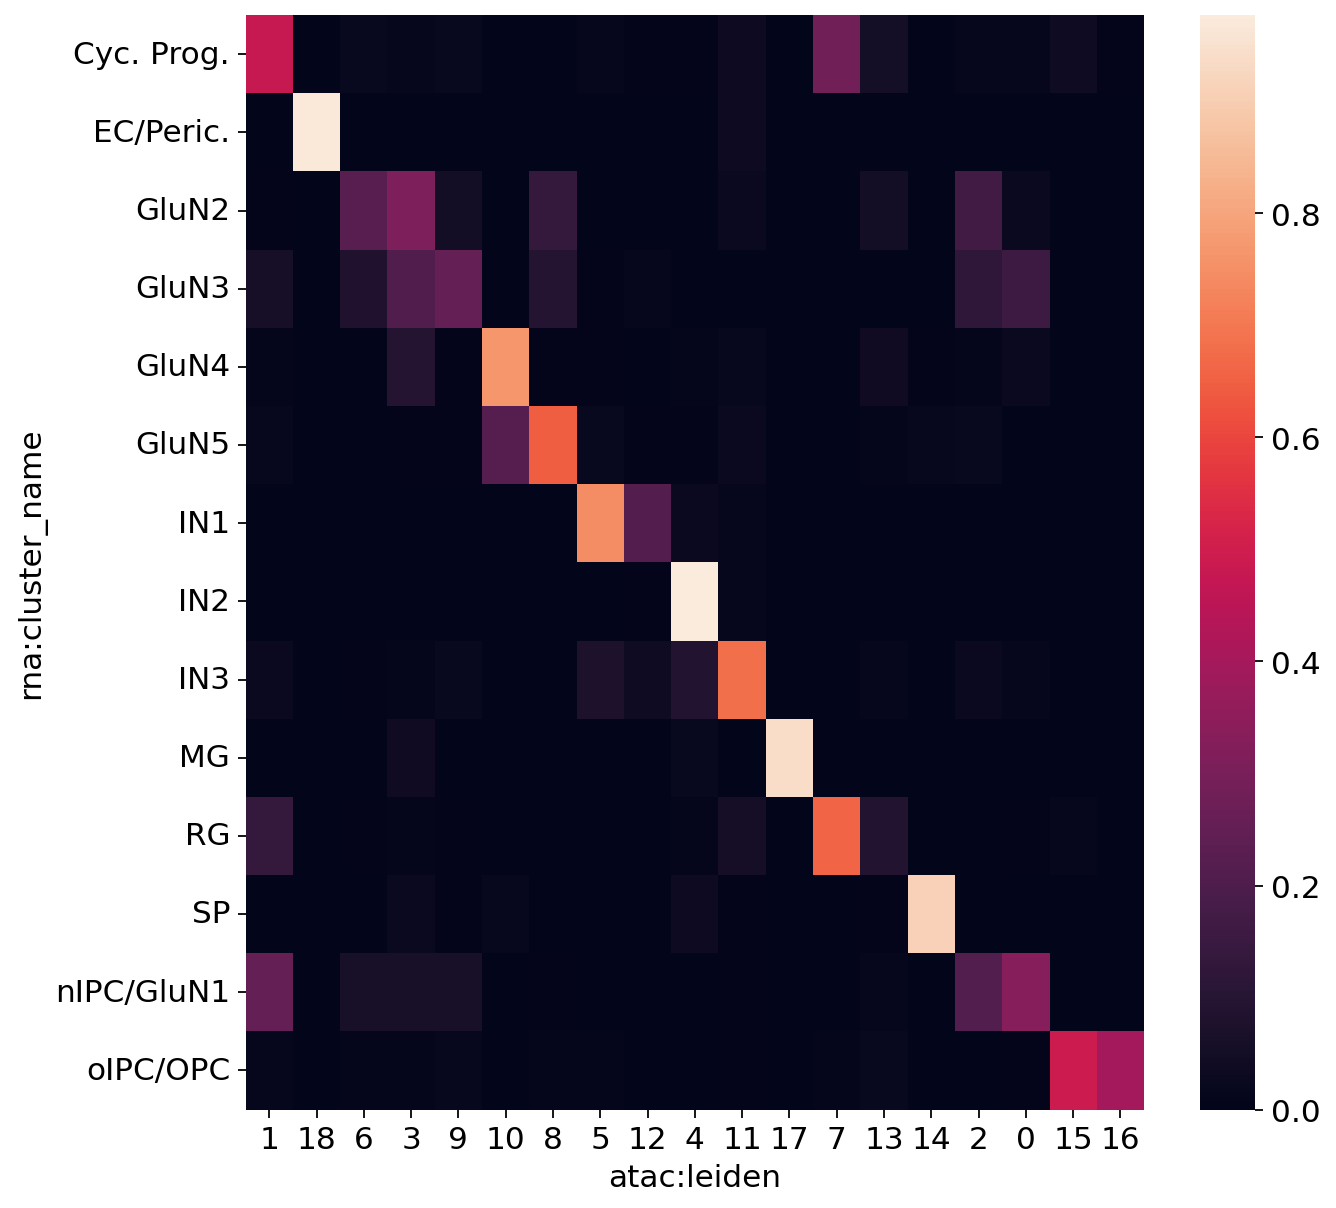

In [30]:
conf_matrix = sc.metrics.confusion_matrix('rna:cluster_name','atac:leiden', mdata.obs[['rna:cluster_name','atac:leiden']])
## reorder columns to get a diagonal
row_order = conf_matrix.idxmax(0).sort_values().index 
conf_matrix = conf_matrix[row_order].copy()
sns.heatmap(conf_matrix)

## Joint embedding of RNA and ATAC modalities

In principle, you could just generate a latent embedding and pseudotime ordering on the scRNA modality, and take that as a representative embedding of your cells. However, it might be beneficial to incorporate information from both modalities in the embedding, using what we defined as "vertical integration" strategies. We recommend trying:

- Multi-omics factors analysis: ([paper](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-02015-1)) 
    - Train model in R ([R package](https://github.com/bioFAM/MOFA2)) ([vignette](https://raw.githack.com/bioFAM/MOFA2_tutorials/master/R_tutorials/10x_scRNA_scATAC.html))
    - Train model in python ([vignette](https://github.com/bioFAM/mofapy2/blob/master/mofapy2/notebooks/getting_started_python.ipynb)) - be aware that you can substitute the `ent.set_data_options` step with `mu.tl._set_mofa_data_from_mudata`, to use directly on MuData objects. Muon also has a MOFA wrapper in `mu.tl.mofa`.
- Seurat V4 Weighted Nearest Neighbor analysis ([paper](https://www.cell.com/cell/fulltext/S0092-8674%2821%2900583-3))
    - Run in R ([vignette](https://satijalab.org/seurat/v4.0/weighted_nearest_neighbor_analysis.html)) - you can refer to the [interoperability notebook](https://github.com/NBISweden/single-cell_sib_scilifelab_2021/blob/main/project_omics/rpy2_interoperability_examples.ipynb) to create a Seurat object and run R code within this notebook 
    - Run in python with [muon wrapper](https://muon.readthedocs.io/en/latest/omics/multi.html#weighted-nearest-neighbours)

<!-- Of note, both of these are re-implemented for MuData objects in `muon` (see [here](https://muon.readthedocs.io/en/latest/omics/multi.html)).  -->
<!-- If you prefer using the native R implementations you can refer to the [python/R interoperability notebook]() to use R code within this notebook.  -->

Other interesting approaches: j-UMAP ([code](https://github.com/canzarlab/JVis-learn)), Schema ([paper](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02313-2)) ([code](https://schema-multimodal.readthedocs.io/en/latest/overview.html)).

It will be interesting to assess what you gain from the joint embedding, in comparison to just using the RNA. It's worth noting that while the differences might be very subtle in the case of RNA-ATAC integration, it has been shown that there is a tangible gain in clustering resolution using these vertical integration strategies on other modalities such as RNA-protein (CITE-seq data).

All the integration tools we try here take some time and resources to run. Therefore you can try out the code, but instead of waiting for long training steps you can load a MuData object already storing the embedding outputs (`vertical_clean_embeddings.h5mu`). Jump to [here](#questions) to start working on exercises.

### Training MOFA

We start by doing some feature selection

In [38]:
## Select highly variable peaks from TF-IDF normalized profiles (not ideal but functional)
sc.pp.highly_variable_genes(mdata["atac"], flavor="seurat",n_top_genes=10000,
                           min_mean=0, max_mean=3, min_disp=0.1)

In [44]:
## Subset the muon object directly
mdata_mofa = mdata.copy()
mdata_mofa.mod["rna"] = mdata_mofa.mod["rna"][:,mdata_mofa.mod["rna"].var["highly_variable"]].copy()
mdata_mofa.mod["atac"] = mdata_mofa.mod["atac"][:,mdata_mofa.mod["atac"].var["highly_variable"]].copy()

# mdata.update()

Training takes approximately ~ 20 mins and ~ 15GB of RAM. To avoid waiting around the results are stored in [here]. Note: there is also a GPU implementation available, that can handle a lot more features and speed up the training significantly (see [MOFA website](https://biofam.github.io/MOFA2/) for more info).

In [49]:
## Run mofapy2
from mofapy2.run.entry_point import entry_point

# initialise the entry point
ent = entry_point()

## Define likelihood distribution for both modalities
# in this case we use gaussian since the data is already normalized (highly recommended)
lik = ['gaussian', 'gaussian']

ent.set_data_options(scale_views=True, scale_groups=False)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Scaling views to unit variance...



In [50]:
## Set up dataset
mu.tl._set_mofa_data_from_mudata(
        model=ent,
        mdata=mdata_mofa,
        likelihoods=lik
)

## Pick model options 
# (most importantly the number of factors)
ent.set_model_options(factors=20)

Loaded view='rna' group='group1' with N=8981 samples and D=5471 features...
Loaded view='atac' group='group1' with N=8981 samples and D=10000 features...


Model options:
- Automatic Relevance Determination prior on the factors: False
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (rna): gaussian
- View 1 (atac): gaussian




In [51]:
## Pick training options 
# (we just use default)
ent.set_train_options()
ent.build()

In [52]:
ent.run()
ent.save(f"{output_dir}/vertical.mofa_trained.h5ad")



######################################
## Training the model with seed 450594 ##
######################################


ELBO before training: -1822054893.96 

Iteration 1: time=55.58, ELBO=-164944018.49, deltaELBO=1657110875.471 (90.94736284%), Factors=20
Iteration 2: time=54.83, ELBO=-164006245.70, deltaELBO=937772.792 (0.05146787%), Factors=20
Iteration 3: time=55.49, ELBO=-163724125.75, deltaELBO=282119.950 (0.01548361%), Factors=20
Iteration 4: time=55.36, ELBO=-163635205.04, deltaELBO=88920.705 (0.00488024%), Factors=20
Iteration 5: time=55.23, ELBO=-163576306.26, deltaELBO=58898.781 (0.00323255%), Factors=20
Iteration 6: time=54.37, ELBO=-163530457.36, deltaELBO=45848.904 (0.00251633%), Factors=20
Iteration 7: time=55.00, ELBO=-163497635.25, deltaELBO=32822.110 (0.00180138%), Factors=20
Iteration 8: time=54.80, ELBO=-163466959.49, deltaELBO=30675.754 (0.00168358%), Factors=20
Iteration 9: time=56.13, ELBO=-163428977.30, deltaELBO=37982.194 (0.00208458%), Factors=20
Iteration 

In [53]:
import h5py
ent = h5py.File(f'{output_dir}/vertical.mofa_trained.h5ad', 'r')
ent.keys()

<KeysViewHDF5 ['data', 'expectations', 'features', 'groups', 'intercepts', 'model_options', 'samples', 'training_opts', 'training_stats', 'variance_explained', 'views']>

When we examine variance explained by the factors in each modality, we can see that factors are mostly driven by which modality

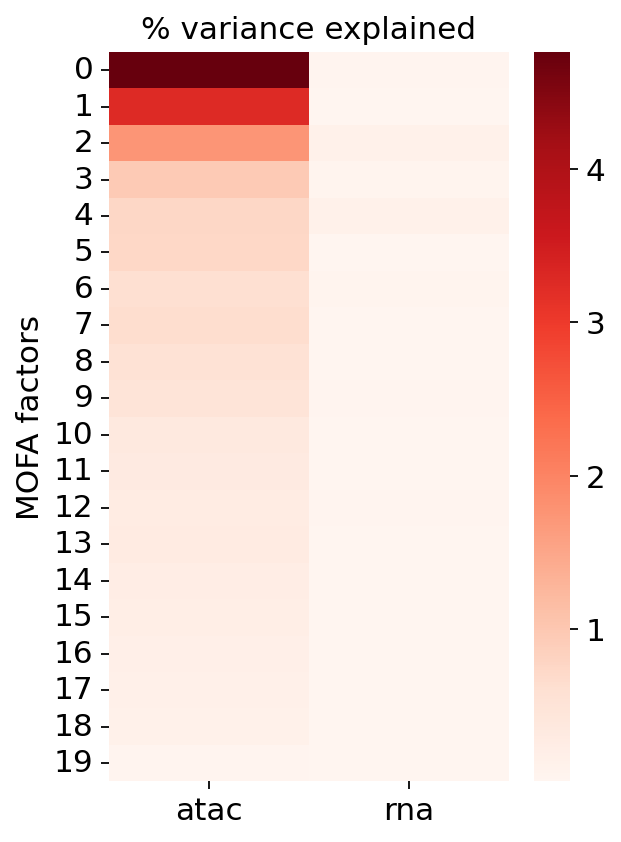

In [54]:
X_mofa = np.array(ent["expectations"]["Z"]["group1"])

plt.rcParams["figure.figsize"] = [4,6]
modalities = list(ent["data"].keys())
r2_matrix = pd.DataFrame(np.array(ent["variance_explained"]["r2_per_factor"]["group1"]).T, columns=modalities)
sns.heatmap(r2_matrix, cmap="Reds");
plt.ylabel("MOFA factors");
plt.title("% variance explained");

In [55]:
## Add MOFA embedding to the muon object
mdata.obsm['X_mofa'] = X_mofa.T

In [56]:
## Calculate KNN graph and UMAP from the MOFA latent factors
# (remember to use scanpy.pp.neighbors, not muon.pp.neighbors)
mdata.uns = {}
sc.pp.neighbors(mdata, use_rep="X_mofa", key_added="mofa")
sc.tl.umap(mdata, neighbors_key="mofa")

In [57]:
mdata.obsm["X_umap_mofa"] = mdata.obsm["X_umap"].copy() 

### WNN embedding

This uses the KNN graphs for each individual modality, stored in `mdata['rna'].obsp` and `mdata['atac'].obsp`. Therefore changing the dimensions used to calculate KNN graphs in individual modalities will affect the outcome of integration with WNN. 

In [60]:
mdata.update()
# mdata.uns = {} ## try this if mu.pp.neighbors throws error
mu.pp.neighbors(mdata)
mu.tl.umap(mdata)

In [61]:
mdata.obsm["X_umap_WNN"] = mdata.obsm["X_umap"].copy() 

By default, modality weights are added to the `mdata.obs` data frame under the `rna:mod_weight` and `prot:mod_weight`.

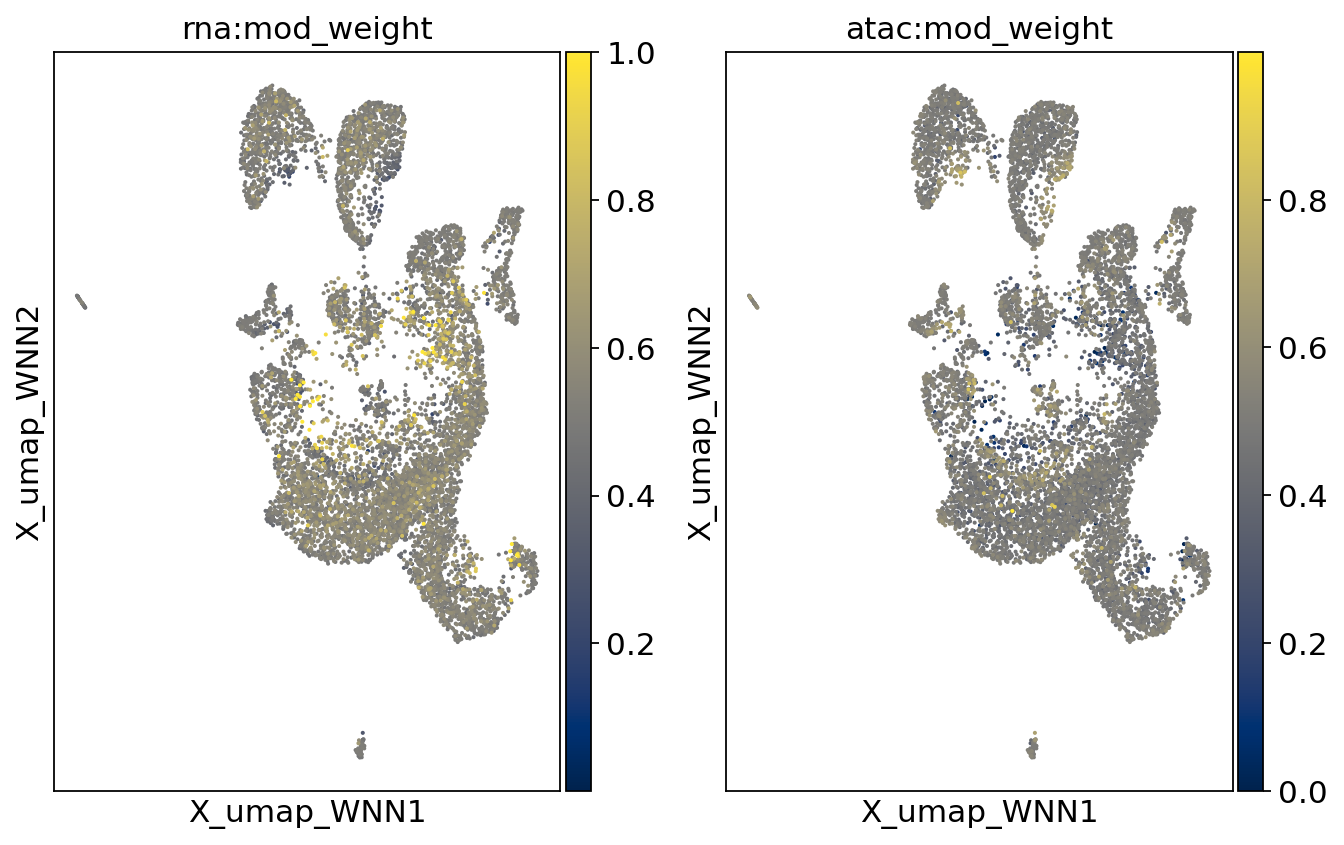

In [62]:
mu.pl.embedding(mdata, basis='X_umap_WNN', color=['rna:mod_weight', 'atac:mod_weight'], cmap='cividis')

Save progress

In [66]:
mdata.write("{d}/vertical_clean_embeddings.h5mu".format(d=output_dir))

In [6]:
output_dir = data_dir
mdata = mu.read("{d}/vertical_clean_embeddings.h5mu".format(d=output_dir))

<a id='questions'></a>
### Question 3
Can you figure out what characterizes cells with much higher RNA modality weight than ATAC modality weight?

... storing 'rna:gene_id' as categorical
... storing 'rna:GeneID' as categorical
... storing 'atac:name' as categorical


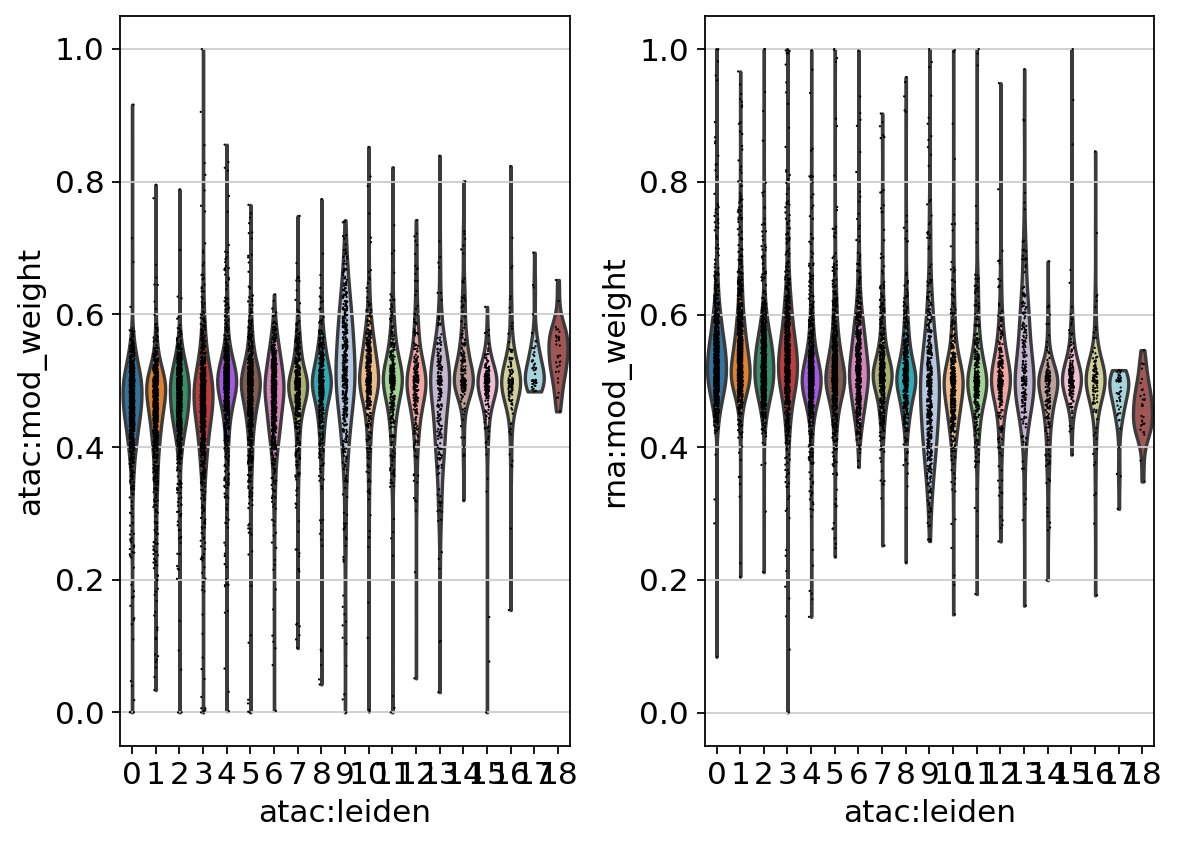

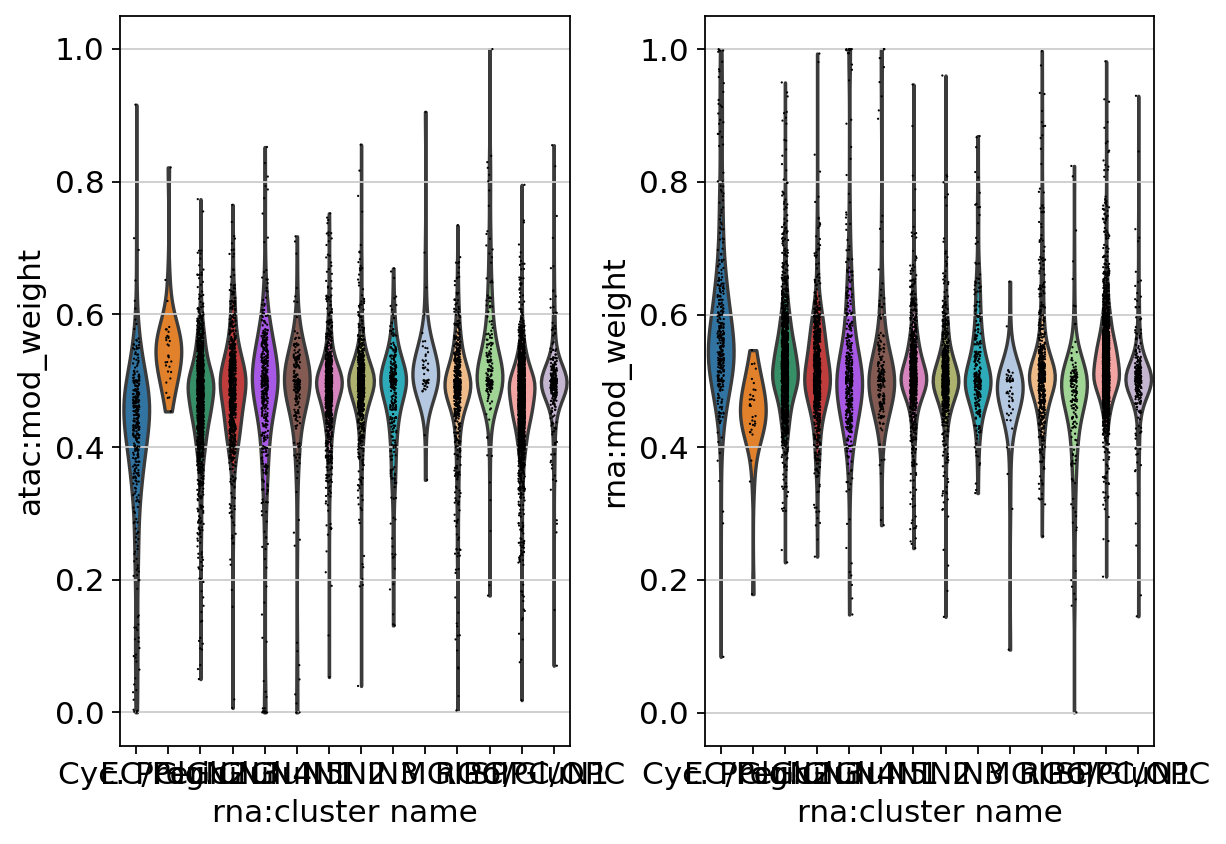

In [63]:
sc.pl.violin(mdata, groupby='atac:leiden', keys=['atac:mod_weight', 'rna:mod_weight'])
sc.pl.violin(mdata, groupby='rna:cluster_name', keys=['atac:mod_weight', 'rna:mod_weight'])

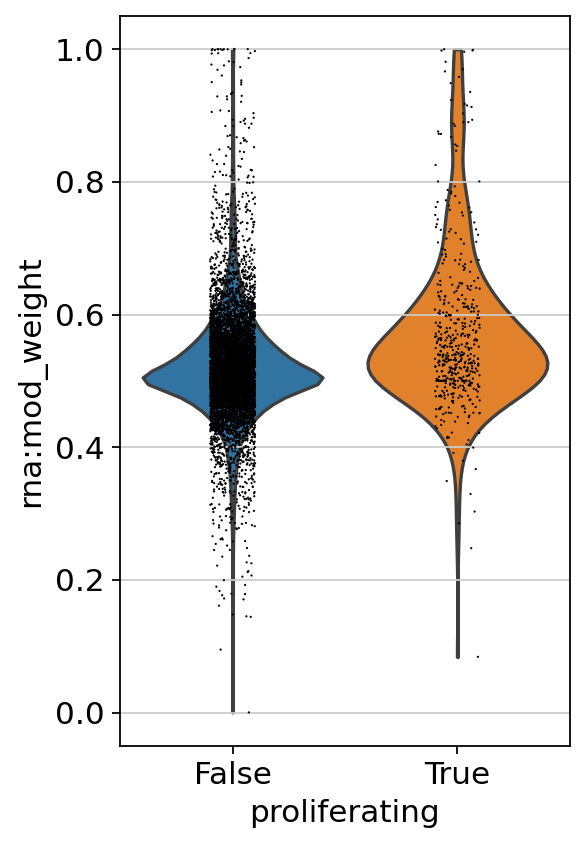

In [64]:
mdata.obs['MKI67_gex'] = mdata['rna'][:,'MKI67'].X.toarray().ravel()
mdata.obs['proliferating'] = (mdata.obs['MKI67_gex'] > 1).astype('category')
sc.pl.violin(mdata, 'rna:mod_weight', groupby='proliferating')

### Compare embeddings 

... storing 'rna:gene_id' as categorical
... storing 'rna:GeneID' as categorical
... storing 'atac:name' as categorical


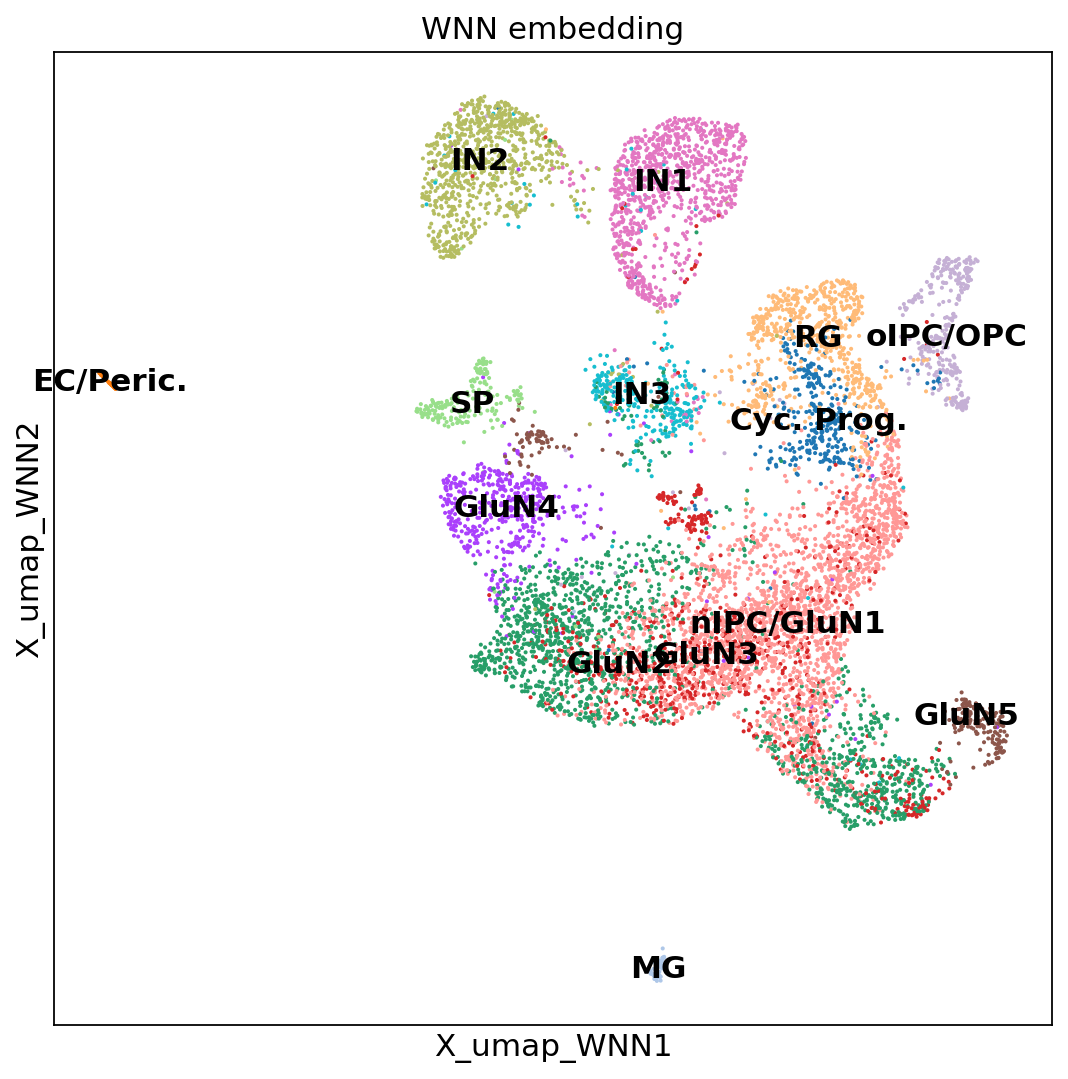

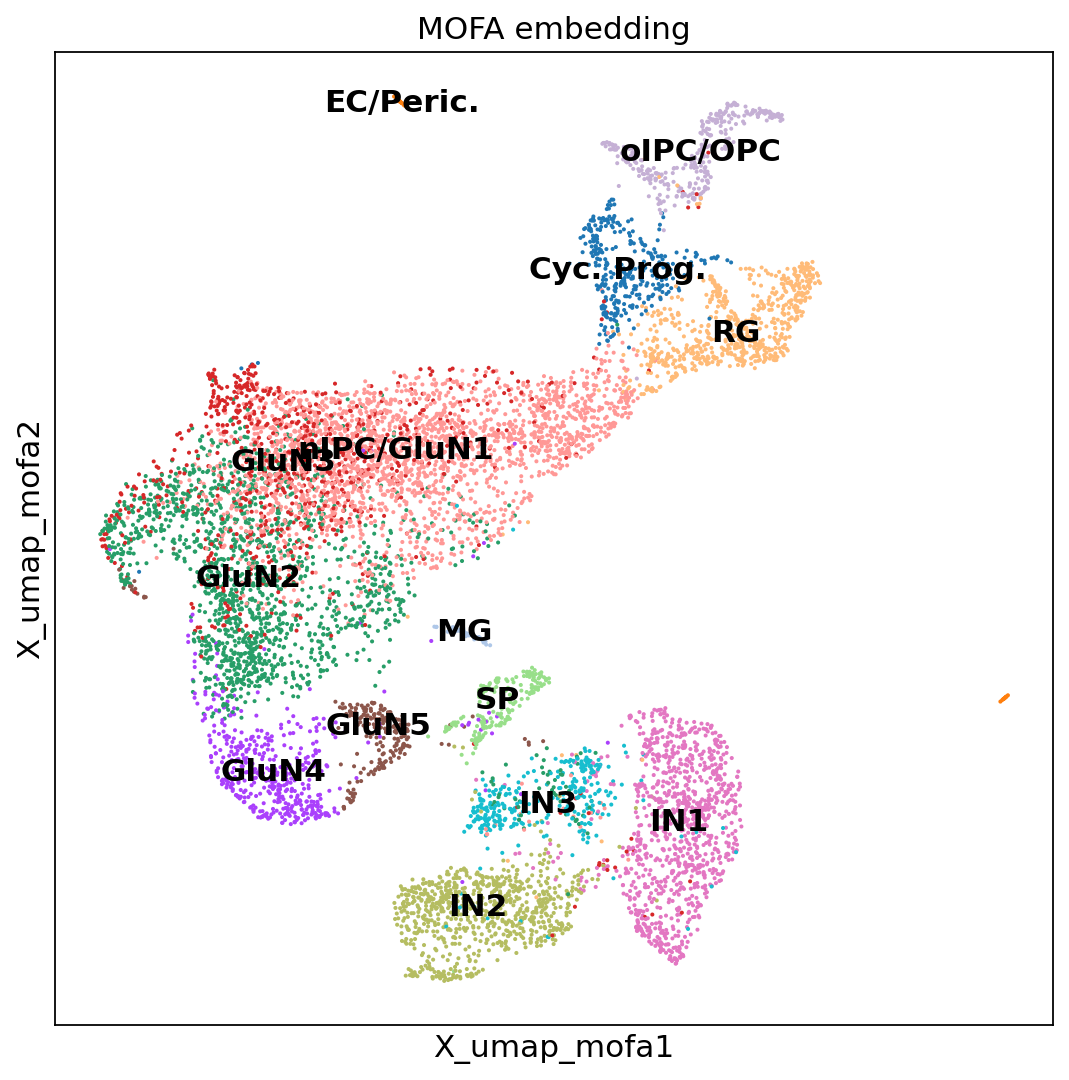

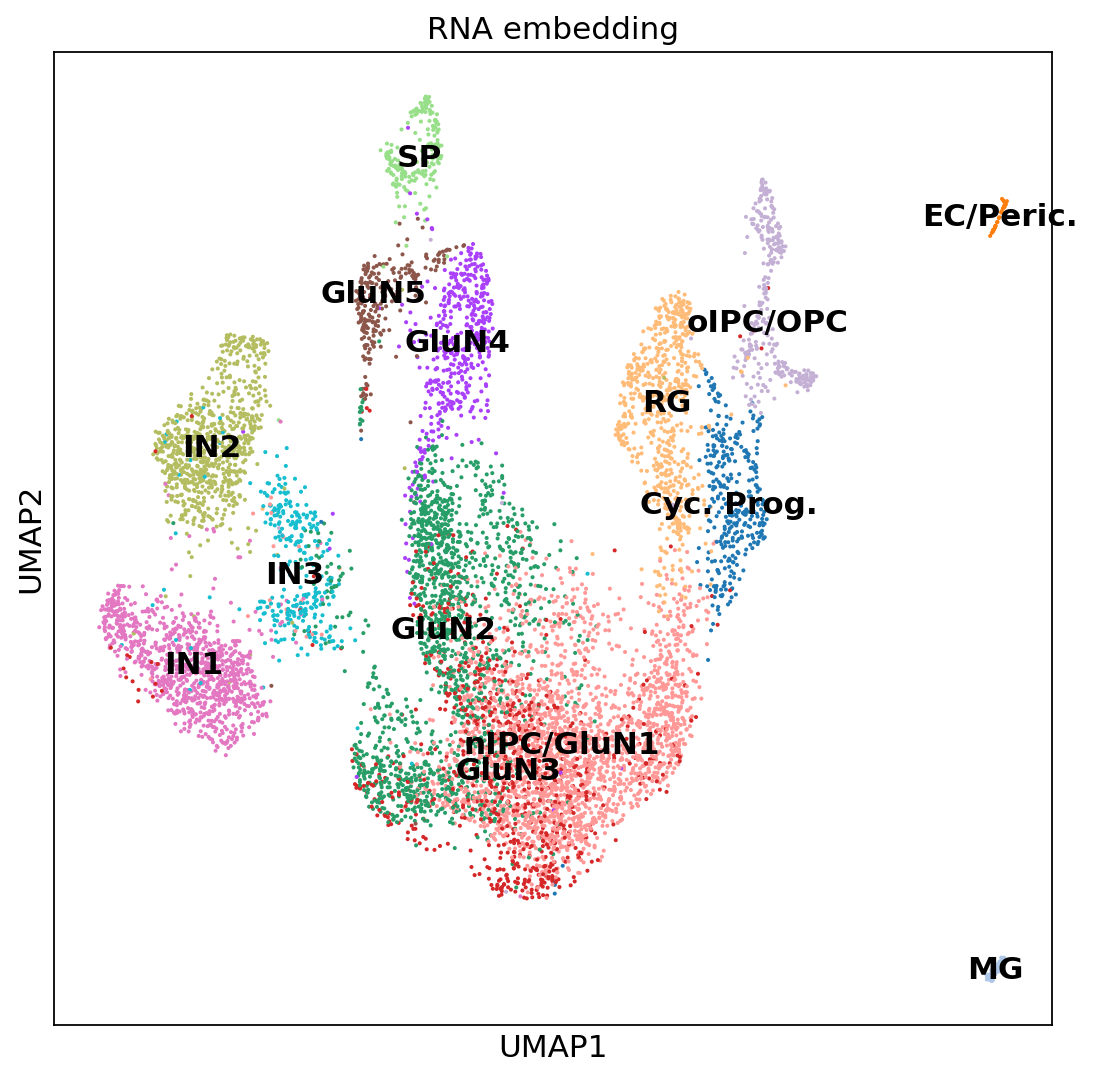

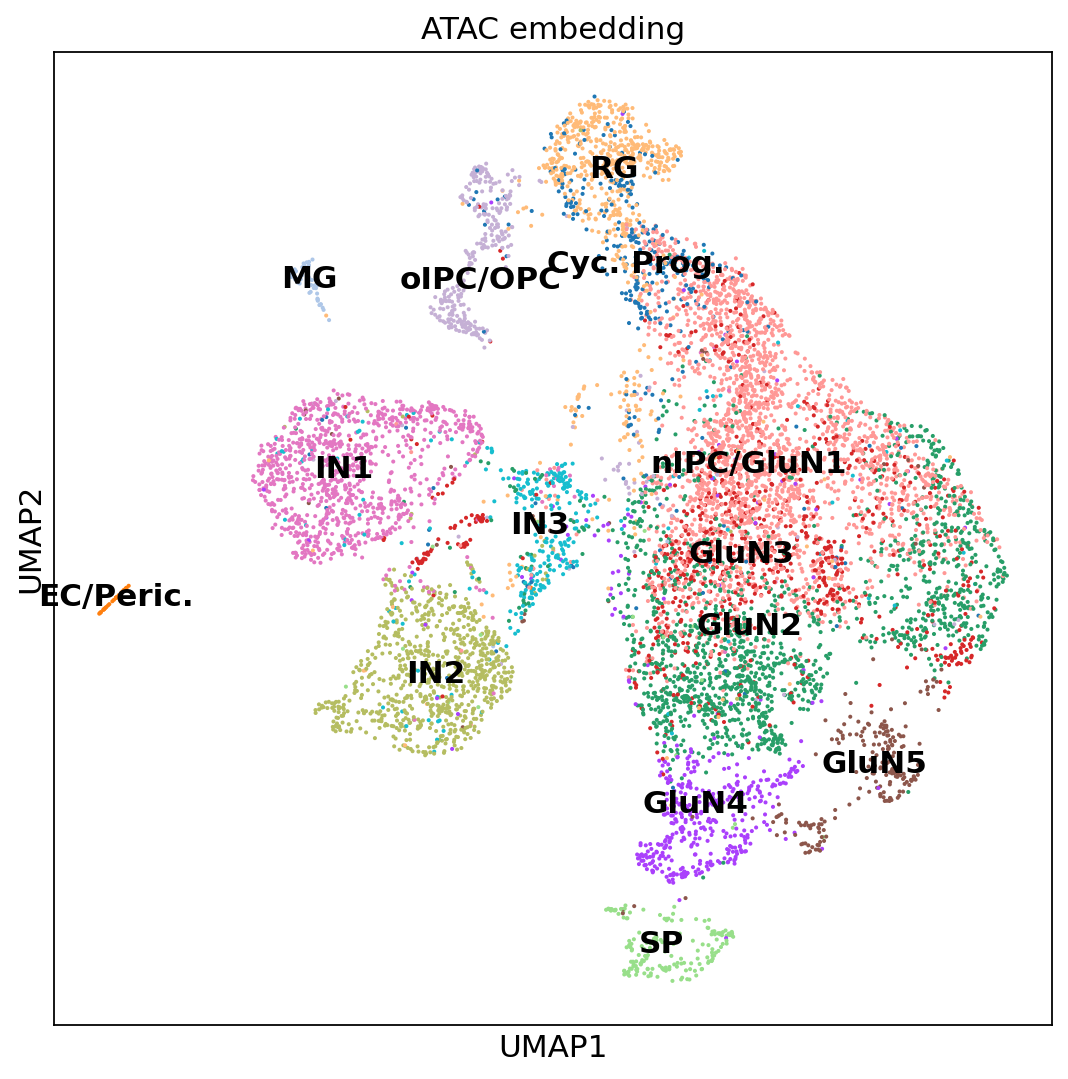

In [67]:
plt.rcParams["figure.figsize"] = [8,8]
sc.pl.embedding(mdata, basis="X_umap_WNN", color="rna:cluster_name", 
                legend_loc="on data", title="WNN embedding")
sc.pl.embedding(mdata, basis="X_umap_mofa", color="rna:cluster_name", 
                legend_loc="on data", title="MOFA embedding")
sc.pl.umap(mdata.mod['rna'], color="cluster_name", 
                legend_loc="on data", title="RNA embedding")

mdata.mod['atac'].obs['rna_cluster_name'] = mdata.obs['rna:cluster_name']
sc.pl.umap(mdata.mod['atac'], color="rna_cluster_name", 
                legend_loc="on data", title="ATAC embedding")

### Question 4
- **Can you quantify which multi-modal embedding (WNN or MOFA) conserves the structure of the individual modalities better?** For example by comparing the agreement of clustering on the multi-modal graph with clustering on both single-omic graphs? Or you could compare the outcome of diffusion based pseudotime ordering (see example on RNA modality [here]())
- **How does the multi-modal integration change if we use a different set of features for the accessibility modality?** You can try running vertical integration methods on accessibility at gene and promoters, instead of highly variable peaks. The accessibility of gene bodies and promoters in stored in `mdata['atac'].obsm['gene_activities']`, as calculated [here](). 

A notable difference in these embeddings is in the separation of the Cycling Progenitor cells, which we don't expect to be distinct in chromatin accessibility profiles. Another difference in the SP cluster (subplate neurons), which is disconnected from GluN neurons in the chromatin accessibility embedding.

Let's compare diffusion pseudotime trajectories: we define the root cell based on RNA embedding

In [146]:
## filter to gluN trajectory 
# (note that clusters are not exactly the same between modalities,
# so pick either annotation in RNA or in ATAC)
mdata = mdata[mdata['rna'].obs['in_GluN_trajectory']].copy()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.

KeyboardInterrupt



In [ ]:
sc.pp.pca(mdata.mod['rna'])
sc.pp.neighbors(mdata.mod['rna'], n_neighbors=10, n_pcs=30)
sc.tl.diffmap(mdata['rna'])

In [ ]:
sc.pl.diffmap(mdata['rna'], color='cluster_name', legend_loc="on data")

In [ ]:
## Define the putative root cell (start of differentiation trajectory)
## we take the maximum for DC1 as the root nIPC
mdata['rna'].uns['iroot'] = mdata['rna'].obsm["X_diffmap"][:,1].argmax() 
mdata.uns['iroot'] = mdata['rna'].obsm["X_diffmap"][:,1].argmax() 

sc.tl.dpt(mdata['rna'])
mdata.obs["dpt_pseudotime_rna"] = mdata['rna'].obs.dpt_pseudotime

In [ ]:
## DPT on MOFA 
sc.pp.neighbors(mdata, use_rep="X_mofa", key_added="mofa")
sc.tl.diffmap(mdata, neighbors_key='mofa')
sc.tl.dpt(mdata, neighbors_key="mofa")
mdata.obs["dpt_pseudotime_MOFA"] = mdata.obs.dpt_pseudotime

In [ ]:
## DPT on WNN
# recompute on subset
sc.pp.neighbors(mdata["rna"], use_rep="X_pca", n_neighbors=10, n_pcs=30)
sc.pp.neighbors(mdata["atac"], use_rep="X_lsi", n_neighbors=10, n_pcs=30)
mu.pp.neighbors(mdata) 

In [ ]:
sc.tl.diffmap(mdata)
sc.tl.dpt(mdata)
mdata.obs["dpt_pseudotime_WNN"] = mdata.obs.dpt_pseudotime

We can compare the pseudotime ordering from the different embeddings

In [ ]:
sc.pl.scatter(mdata, 'dpt_pseudotime_rna', 'dpt_pseudotime_WNN', color="rna:cluster_name")
sc.pl.scatter(mdata, 'dpt_pseudotime_rna', 'dpt_pseudotime_MOFA', color="rna:cluster_name")
sc.pl.scatter(mdata, 'dpt_pseudotime_WNN', 'dpt_pseudotime_MOFA', color="rna:cluster_name")

The multi-omic embeddings seem to distinguish better cluster GluN5 and GluN4 in pseudotime ordering.

In [ ]:
mdata.var_names_make_unique()

In [ ]:
sc.pl.violin(mdata, ["dpt_pseudotime_rna", "dpt_pseudotime_WNN", "dpt_pseudotime_MOFA"], groupby="rna:cluster_name")